In [1]:
import numpy as np
import scipy
import scipy.stats
import torch as t
import matplotlib.pyplot as plt

In [2]:
from torch.nn import Sequential, Linear, ReLU, LeakyReLU, Dropout, Sigmoid

In [3]:
%matplotlib inline

In [4]:
if t.cuda.is_available():
    if t.cuda.device_count()>1:
        device = t.device('cuda:1')
    else:
        device = t.device('cuda')   
else:
    device = t.device('cpu')

In [5]:
d1_dist = scipy.stats.norm(loc=3,scale=2)
d2_dist = scipy.stats.norm(loc=0,  scale=0.5)

In [6]:
d1 = d1_dist.rvs(size=50000).astype('float32')
d2 = d2_dist.rvs(25000).astype('float32')

In [7]:
def p_data(x):
    return 2/3*d1_dist.pdf(x)+1/3*d2_dist.pdf(x)

In [8]:
data =np.concatenate((d1,d2)) 
np.random.shuffle(data)
data_t = t.from_numpy(data).view(-1,1)

In [9]:
data_t

tensor([[-0.1511],
        [ 5.8021],
        [ 3.1821],
        ...,
        [-0.8136],
        [-0.3738],
        [ 1.6336]])

In [10]:
ys = np.linspace(-5,10,100).astype('float32')

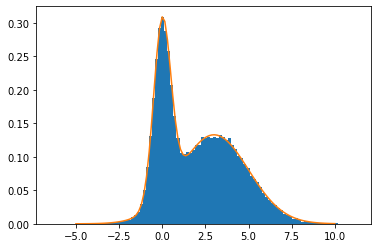

In [11]:
plt.hist(data, bins=100, density=True);
plt.plot(ys, p_data(ys))

In [12]:
noise_dist=scipy.stats.uniform(loc=0, scale=1)

## Inverse cumulant

In [13]:
us = np.linspace(0,1,100).astype('float32')
us_t = t.from_numpy(us).view(-1,1)

In [14]:
def f_generator(u):
    return t.log(u/(1-u))

$$ Y = \log\left(\frac{u}{1-u}\right)$$

$$CDF_{Y}(x)=P(Y<y)$$ 

$$P(\log\left(\frac{u}{1-u}\right)<y)$$ 

$$P\left(\frac{u}{1-u}<e^y\right)$$ 

$$P\left(u<e^y-u e^y\right)$$ 

$$P\left(u(1+ e^y)<e^y\right)$$ 

$$P\left(u<\frac{e^y}{1+ e^y}\right)=\frac{e^y}{1+ e^y}=\frac{1}{1+ e^{-y}} $$ 

$$PDF_Y(x) = \frac{\partial}{\partial y}\frac{1}{1+ e^{-y}}=\frac{e^{-y}}{(1+e^{-y})^2}$$

In [15]:
def p_gen(y):
    e = np.exp(-y)
    return e/((1+e)*(1+e))

In [16]:
p_ys = p_gen(ys).reshape(-1,1)

In [17]:
gen = f_generator(t.FloatTensor(10000,1).uniform_(0,1))

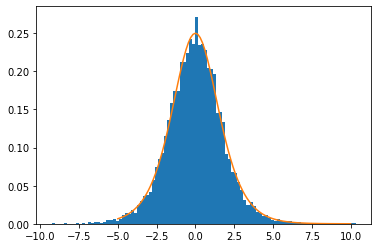

In [18]:
plt.hist(gen.data.numpy().reshape(-1), bins=100, density=True);
plt.plot(ys, p_ys);

### Data

In [19]:
n = 1000
xs = np.linspace(-5,10,n+1)
pdf_data = p_data(xs)
cum_data = np.cumsum(pdf_data)*15/n
cum_data[0]=0.0
cum_data[-1]=1.0

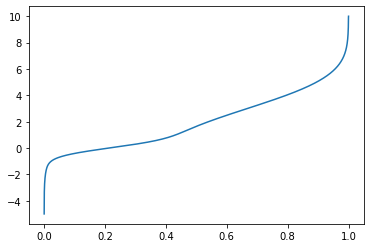

In [20]:
plt.plot(cum_data,xs)

In [21]:
from scipy.interpolate import interp1d

In [22]:
inv_cum_data = interp1d(cum_data, xs,3)

In [23]:
fake_data = inv_cum_data(np.random.uniform(0,1,100000))

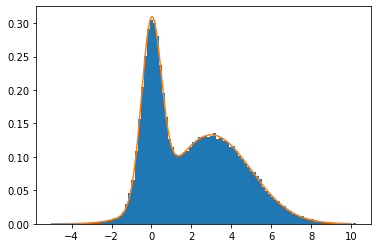

In [24]:
plt.hist(fake_data, bins=100, density=True);
plt.plot(xs, p_data(xs));

## Generative Adversarial Network

In [25]:
def makeNet(n_layers, n_neurons_in_last_layer):
    n = n_layers-1
    n_neurons_in_first_layer = n_neurons_in_last_layer*(2**(n-1))
    modules=[]
    modules.append(Linear(in_features=1, out_features=n_neurons_in_first_layer))
    modules.append(LeakyReLU())
    for i in range(n-1):
        modules.append(Linear(in_features=n_neurons_in_first_layer, out_features=n_neurons_in_first_layer//2))
        modules.append(LeakyReLU())
        n_neurons_in_first_layer//=2
    modules.append(Linear(in_features=n_neurons_in_last_layer, out_features=1))
   
    return Sequential(*modules)

In [26]:
discriminator = Sequential(Linear(1,512), LeakyReLU(0.2, inplace=True),
                           Linear(512,32), LeakyReLU(0.2, inplace=True),
                           Linear(32,1),  Sigmoid()
                                     )

In [27]:
discriminator=discriminator.to(device)
data_t = data_t.to(device)

In [28]:
d_optimizer = t.optim.Adam(discriminator.parameters(), lr=0.0002)

In [29]:
bce = t.nn.BCELoss()

In [30]:
d_out = discriminator(t.from_numpy(ys).view(-1,1).to(device))

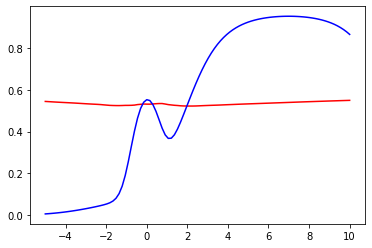

In [31]:
plt.plot(ys,d_out.data.cpu().numpy().reshape(-1),c='r');
plt.plot(ys, p_data(ys)/(p_data(ys)+p_gen(ys)),c='b');

In [32]:
generator = makeNet(5,32)

In [33]:
print(generator)

Sequential(
  (0): Linear(in_features=1, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=32, out_features=1, bias=True)
)


In [34]:
generator= generator.to(device)

In [35]:
out_t = generator(t.FloatTensor(us_t).to(device));

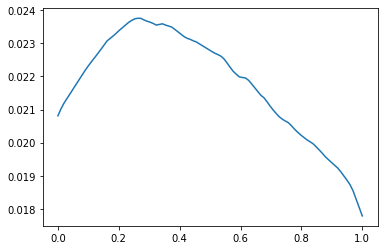

In [36]:
plt.plot(us, out_t.data.cpu().numpy().reshape(-1))

In [37]:
g_optimizer = t.optim.Adam(generator.parameters(), lr=0.0002)

In [38]:
gen = generator(t.empty(10000,1).uniform_(-1,1).to(device))

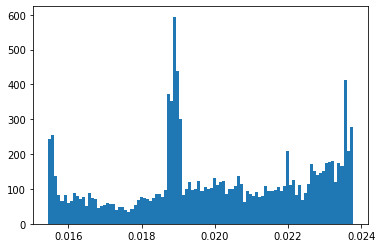

In [39]:
plt.hist(gen.data.cpu().numpy().reshape(-1), bins=100, density=True);
#plt.plot(ys, p_data(ys));

In [40]:
-np.log(0.5)

0.6931471805599453

In [41]:
mini_batch_size = 2048
k_discriminator = 12
k_generator = 1
for epoch in range(1,201):
    for batch in range(len(data)//mini_batch_size):
        for k_d in range(k_discriminator):
            d_optimizer.zero_grad()
            kr = np.random.randint(0,len(data)//mini_batch_size )
          
            d = data_t[kr*mini_batch_size:(kr+1)*mini_batch_size]
            real_labels = t.ones(mini_batch_size, 1, device=device)
            d_real_loss = bce(discriminator(d), 0.9*real_labels)
      
            z = t.empty(mini_batch_size,1, device=device).uniform_(-1,1)
            g_out = generator(z)
            fake_labels = t.zeros(mini_batch_size, 1, device=device)
            d_fake_loss = bce(discriminator(g_out), fake_labels)
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
    
        g_optimizer.zero_grad()
        z = t.empty(mini_batch_size,1, device=device).uniform_(-1,1)
        g_out = generator(z)
        g_loss = bce(discriminator(g_out), real_labels)
        g_loss.backward()
        g_optimizer.step()
        
    if epoch%5 == 0:
        with t.no_grad():
                z = t.empty(len(data_t),1, device=device).uniform_(-1,1)
                real_labels = t.ones(len(data_t),1, device=device)
                fake_labels = t.zeros(len(data_t),1, device=device)
                g_out =  generator(z)
                dg_out = discriminator(g_out)
                d_loss =  bce(discriminator(data_t), real_labels)
                d_loss +=  bce(dg_out, fake_labels)
                
                g_loss = bce(dg_out, real_labels)
                
                print(epoch, d_loss.item(), g_loss.item())     

5 1.3679485321044922 0.8144615888595581
10 1.372945785522461 0.8047529458999634
15 1.3838768005371094 0.827799916267395
20 1.3873789310455322 0.8348183035850525
25 1.3852341175079346 0.8231152892112732
30 1.3778235912322998 0.7916216850280762
35 1.3790556192398071 0.7988837361335754
40 1.3848645687103271 0.8043307065963745
45 1.3882821798324585 0.8044396638870239
50 1.3897556066513062 0.8080999255180359
55 1.389251470565796 0.7930432558059692
60 1.3905794620513916 0.8385722637176514
65 1.3892672061920166 0.7867472171783447
70 1.3881416320800781 0.7966575026512146
75 1.3927010297775269 0.8089472055435181
80 1.3899257183074951 0.7995430827140808
85 1.3878068923950195 0.7901945114135742
90 1.3907790184020996 0.7907605767250061
95 1.3935426473617554 0.8202030062675476
100 1.3916791677474976 0.7967673540115356
105 1.3944015502929688 0.80064457654953
110 1.3946641683578491 0.8152185678482056
115 1.3906081914901733 0.7815003395080566
120 1.3948289155960083 0.8229042887687683
125 1.39259874820

In [42]:
gen = generator(t.empty(100000,1).uniform_(-1,1).to(device))

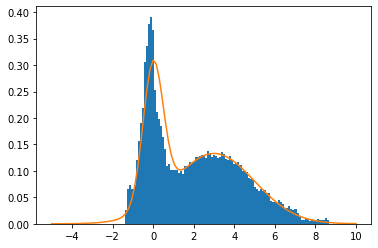

In [43]:
plt.hist(gen.data.cpu().numpy().reshape(-1), bins=100, density=True);
plt.plot(ys, p_data(ys));

In [44]:
d_out = discriminator(t.from_numpy(ys).to(device).view(-1,1))

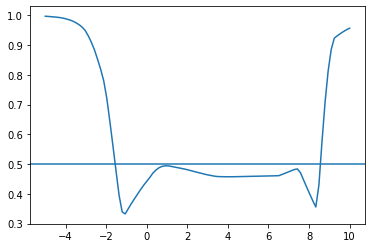

In [45]:
plt.plot(ys,d_out.data.cpu().numpy().reshape(-1));
plt.axhline(0.5);

In [46]:
out_t = generator(t.linspace(-1,1,100).view(-1,1).to(device));

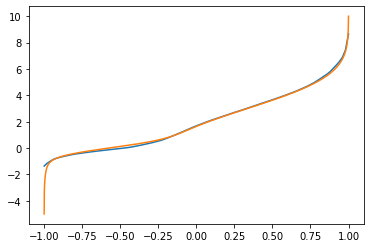

In [47]:
plt.plot(np.linspace(-1,1,100), out_t.data.cpu().numpy().reshape(-1))
plt.plot(2*cum_data-1, xs);
